In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
import os
import torch
from torchvision import datasets
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import r2_score
from scipy.stats import kendalltau

In [2]:
results_MNIST_CNN = np.load('../experimentresults/MNIST2_CNN_100_models_results.npy',allow_pickle=True).item()
results_MNIST_MLP = np.load('../experimentresults/MNIST2_MLP_100_models_results.npy',allow_pickle=True).item()
results_CIFAR_CNN = np.load('../experimentresults/CIFAR2_CNN_100_models_results.npy',allow_pickle=True).item()
results_FMNIST_CNN = np.load('../experimentresults/FMNIST2_CNN_100_models_results.npy',allow_pickle=True).item()

In [3]:
#results_MNIST_CNN
results_MNIST_MLP.keys()

dict_keys(['N', 'W', 'Omega', 'gamma', 'P', 'test_acc_NN', 'train_acc_NN', 'test_acc_kSVM', 'confidences_NN', 'L2CosSim', 'L2CosSim_corr', 'SEED', 'overlap_misclassified_kSVM_models', 'overlap_misclassified_NN_models', 'correct_NN_vector', 'correct_kSVM_vector', 'test_acc_LKR', 'correct_LKR_vector', 'logits_LKR', 'logits_NN', 'logits_kSVM'])

In [10]:
from scipy.optimize import minimize
from scipy.special import erf
from scipy.stats import norm
from math import log
from sklearn.metrics import r2_score

def model_inv(x,A,K,nu):
    #return  K * np.log((x**nu) / (1-x**nu)) + A
    return  K * (nu*np.log(x) - np.log(1-x**nu)) + A 

def model_inv_tan(x,A,K,nu):
    return -K * np.tan(np.pi/2 - np.pi*x**nu) + A

def inv_model_tan(x,A,K,nu):
    return (-np.arctan((x-A)/(-K)) + np.pi/2)**(1/nu)
    
def inv_model(x,A,K,nu):
    F = np.exp((x-A)/K)
    return (F/(1+F))**(1/nu)
    
def logit(p):
    return np.log(p/(1-p))

def inverse_softmax(p):
    return  p/(1-p)

def loss(Theta,GLM_logits,NN_p,TANGENT=False):
    A = Theta[0]
    K = Theta[1]
    nu = Theta[2]
    
    NN_linearized_logits = model_inv(NN_p,A,K,nu)
    
    if isinstance(GLM_logits,torch.Tensor):
        GLM_logits = GLM_logits.numpy()
        
    loss = np.mean((NN_linearized_logits-GLM_logits)**2)
    
    return loss

def linloss(Theta,X,NNY,TANGENT=False):
    M = Theta[0]
    B = Theta[1]
    
    YGLM = X * M + B
        
    loss = np.mean((YGLM-NNY)**2)
    
    return loss

def softmax_numpy(x):
    return np.exp(x) / np.sum(np.exp(x))

def make_my_forward_fit(logits_GLM,
                        logits_NN,
                        PLOT_LOGITS=True,
                        method=None,
                        constraints=[(None,None),(None,None),(0.2,2.0)],
                        x0=np.array([0.0,1,1.1,])):
    '''
    Here I want to linearize the NN output Y. I'll do that by using a correlation loss to X.
    '''
    X = logits_GLM
    Y = logits_NN

    
    #mask out uber probabilities
    mask = np.logical_or(Y==1.0,Y==0)
    
    X=X[~mask]
    Y=Y[~mask]
    
    #We can estimate the slope from the given data.
    x0[1] = X.std() 
    
    res = minimize(loss,x0=x0,args=(X,Y),bounds=constraints,method=method)
    
    A =res.x[0]
    K =res.x[1]
    nu = res.x[2]

    #Y_linearized_end = model_inv(Y,A,K,nu)
    X_linearized_end = logit(inv_model(X,A,K,nu)) #maps logits GLM -> P_c_class
    
    
    mask_0 = np.zeros(len(logits_NN),dtype=bool)
    mask_0[0:int(len(logits_NN)/2)] = 1
    mask_1 = np.zeros(len(logits_NN),dtype=bool)
    mask_1[int(len(logits_NN)/2)::] = 1
    
    mask_0 = mask_0[~mask[:,0]]
    mask_1 = mask_1[~mask[:,0]]
    
    
    plt.hlines(0.5,min(X_linearized_end),max(X_linearized_end),color='tab:green',linestyle='dashed',label="NN Decision Boundary")
    plt.vlines(inv_model(0.5,A,K,nu),min(logit(Y)),max(logit(Y)),color='tab:red',linestyle='dashed',label='LogisticRegression Decision Boundary')
    plt.scatter(X_linearized_end[mask_1],logit(Y)[mask_1],alpha=0.15,label='True Class=1')
    plt.scatter(X_linearized_end[mask_0],logit(Y)[mask_0],alpha=0.15,label='True Class=0')
    plt.plot([min(logit(Y)),max(logit(Y))],[min(logit(Y)),max(logit(Y))],'k--',label='logistic regression fit')
    #plt.plot(X,X,'.',alpha=0.3,color='k',label='logistic regression fit')
    
    #R_squared = (np.corrcoef(X,Y_linearized_end)[0,1])**2
    try:
        R_squared = r2_score(X_linearized_end,logit(Y))
        
    except ValueError:
        R_squared = np.nan
        
    try:
        res = kendalltau(X,logit(Y))
        #res = kendalltau(X,Y)
        Tau = res.correlation
    except ValueError:
        Tau = np.nan
    
    if not(R_squared is np.nan):
        pass
        plt.text(0.95*min(X_linearized_end),0.75*max(logit(Y)),'R^2={:.3f}'.format(R_squared),fontsize=15)
    #plt.legend(bbox_to_anchor=(1.05,0.5),fontsize=12)
    #plt.show()

    return R_squared, Tau


def make_no_forward_fitSVM(logits_GLM,
                    logits_NN,
                    PLOT_LOGITS=True,
                    method=None,
                    constraints=[(None,None),(None,None)],
                    x0=np.array([1,0,])):
    

    
    X = logits_GLM #these are the oriignal activations
    Y = logits_NN #these are already softmax-scaled
    
    if len(constraints)>2:
        constrains = constraints[0:2]
    if len(x0)>2:
        x0 = x0[0:2]
    
    #we need to have the sofmax-scaled X.
    #X = softmax_numpy(X)
    
    #I used predict_log_proba... 
    # = np.exp(X[:,1])[:,None]
    X = X[:,1]
    X = X[:,None]
    
    mask = np.logical_or(np.logical_or(Y==1.0,Y==0),np.logical_or(X==0,X==1.0))

    X=X[~mask]
    Y=Y[~mask]
    
    Tau = kendalltau(X,Y).correlation #TAU IS computed before the linear relationship is scaled.
    
    #Now take logit fn across class c
    Y = logit(Y)
    X = logit(X)
    
    mask2 = np.logical_or(np.isnan(X),np.isnan(Y))
    X=X[~mask2]
    Y=Y[~mask2]
    
    try:
        x0[0] = (max(Y)-min(Y)) / (max(X)-min(X)) #guess slope
    except:
        return np.nan, np.nan
    x0[1] = -np.mean(X)*x0[0] #guess bias
    res = minimize(linloss,x0=x0,args=(X,Y),bounds=constraints,method=method)
    
    
    
    M = res.x[0]
    B = res.x[1]
    X = X*M + B

    if PLOT_LOGITS:
        mask_0 = np.zeros(len(logits_NN),dtype=bool)
        mask_0[0:int(len(logits_NN)/2)] = 1
        mask_1 = np.zeros(len(logits_NN),dtype=bool)
        mask_1[int(len(logits_NN)/2)::] = 1

        mask_0 = mask_0[~mask[:,0]][~mask2]
        mask_1 = mask_1[~mask[:,0]][~mask2]


        plt.hlines(0.0,min(X),max(X),color='tab:green',linestyle='dashed',label="NN Decision Boundary")
        plt.vlines(0.0,min(Y),max(Y),color='tab:red',linestyle='dashed',label='LogisticRegression Decision Boundary')
        plt.scatter(X[mask_1],Y[mask_1],alpha=0.15,label='True Class=1')
        plt.scatter(X[mask_0],Y[mask_0],alpha=0.15,label='True Class=0')
        plt.plot([min(Y),max(Y)],[min(Y),max(Y)],'k--',label='Parity')
    
    R_squared = r2_score(X,Y)

    return R_squared, Tau

def make_no_forward_fit(logits_GLM,
                    logits_NN,
                    PLOT_LOGITS=True,
                    method=None,
                    constraints=[(None,None),(None,None)],
                    x0=np.array([1,0,])):
    

    
    X = logits_GLM #these are the oriignal activations
    Y = logits_NN #these are already softmax-scaled
    
    if len(constraints)>2:
        constrains = constraints[0:2]
    if len(x0)>2:
        x0 = x0[0:2]
    
    #we need to have the sofmax-scaled X.
    X = softmax_numpy(X)
    
    
    mask = np.logical_or(np.logical_or(Y==1.0,Y==0),np.logical_or(X==0,X==1.0))

    X=X[~mask]
    Y=Y[~mask]
    
    Tau = kendalltau(X,Y).correlation #TAU IS computed before the linear relationship is scaled.
    
    #Now take logit fn across class c
    Y = logit(Y)
    X = logit(X)
    
    mask2 = np.logical_or(np.isnan(X),np.isnan(Y))
    X=X[~mask2]
    Y=Y[~mask2]
    
    try:
        x0[0] = (max(Y)-min(Y)) / (max(X)-min(X)) #guess slope
    except:
        return np.nan, np.nan
    x0[1] = -np.mean(X)*x0[0] #guess bias
    res = minimize(linloss,x0=x0,args=(X,Y),bounds=constraints,method=method)
    
    
    
    M = res.x[0]
    B = res.x[1]
    X = X*M + B

    if PLOT_LOGITS:
        mask_0 = np.zeros(len(logits_NN),dtype=bool)
        mask_0[0:int(len(logits_NN)/2)] = 1
        mask_1 = np.zeros(len(logits_NN),dtype=bool)
        mask_1[int(len(logits_NN)/2)::] = 1

        mask_0 = mask_0[~mask[:,0]][~mask2]
        mask_1 = mask_1[~mask[:,0]][~mask2]


        plt.hlines(0.0,min(X),max(X),color='tab:green',linestyle='dashed',label="NN Decision Boundary")
        plt.vlines(0.0,min(Y),max(Y),color='tab:red',linestyle='dashed',label='LogisticRegression Decision Boundary')
        plt.scatter(X[mask_1],Y[mask_1],alpha=0.15,label='True Class=1')
        plt.scatter(X[mask_0],Y[mask_0],alpha=0.15,label='True Class=0')
        plt.plot([min(Y),max(Y)],[min(Y),max(Y)],'k--',label='Parity')
    
    R_squared = r2_score(X,Y)

    return R_squared, Tau

In [15]:
def read_results(results,filepath='tmp.pdf',suptitle='tmp',method='nelder-mead',):
    
    for key in ['train_acc_NN','test_acc_NN','test_acc_kSVM','test_acc_LKR',]:
        mu = np.mean(results[key])
        std_var_of_mu = np.std(results[key]) / np.sqrt(len(results[key]))
        
        print('{} {:.2f} +/- {:.2f} %'.format(key,100*mu,100*std_var_of_mu))

    logits_LKR = results['logits_LKR']
    logits_NN = results['logits_NN']

    
    if True:
        fitted_r2_scores = []
        tau = []
        for i in range(100):
            FLAG=False
            if 'FMNIST' in filepath and (i==3 or i==4 or i==5 or i==6):
                FLAG=True
                pass
            if i == 0:
                plt.figure(figsize=(16,16))
            if i < 9:
                if not(FLAG):
                    plt.subplot(3,3,i+1)
                    plt.title(f'Seed {i}')
                else:
                    plt.subplot(3,3,i+1)
                    plt.title(f'Seed {i*10}')
                
            #r2_score_j, tau_j = make_my_forward_fit(results['logits_LKR'][i],results['logits_NN'][i],method=method)
            if not(FLAG):
                r2_score_j, tau_j = make_no_forward_fit(results['logits_LKR'][i],results['logits_NN'][i],method=method)
            else:
                r2_score_j, tau_j = make_no_forward_fit(results['logits_LKR'][i*10],results['logits_NN'][i*10],method=method)
                continue
                
            if i >= 9:
                plt.close()
            if i == 7:
                plt.legend(bbox_to_anchor=(1.1,-0.15),fontsize=16)
            if i == 8:
                plt.suptitle(suptitle,fontsize=20)
                
                plt.show()
            if not(np.isnan(r2_score_j)):
                fitted_r2_scores.append(r2_score_j)
            if not(np.isnan(tau_j)):
                tau.append(tau_j)
    
        fitted_r2_scores=np.array(fitted_r2_scores)
        print("fit R^2 {:.4f} +/- {:.4f}".format(fitted_r2_scores.mean(),
                                         fitted_r2_scores.std()/np.sqrt(len(fitted_r2_scores))))
        tau = np.array(tau)
        print("tau {:.4f} +/- {:.4f}".format(tau.mean(),tau.std()/np.sqrt(len(tau))))
  

In [12]:
def read_resultsSVM(results,filepath='tmp.pdf',suptitle='tmp',method='nelder-mead',):
    
    for key in ['train_acc_NN','test_acc_NN','test_acc_kSVM','test_acc_LKR',]:
        mu = np.mean(results[key])
        std_var_of_mu = np.std(results[key]) / np.sqrt(len(results[key]))
        
        print('{} {:.2f} +/- {:.2f} %'.format(key,100*mu,100*std_var_of_mu))

    logits_LKR = results['logits_kSVM']
    logits_NN = results['logits_NN']

    
    if True:
        fitted_r2_scores = []
        tau = []
        for i in range(100):
            FLAG=False
            if 'FMNIST' in filepath and (i==3 or i==4 or i==5 or i==6):
                FLAG=True
                pass
            if i == 0:
                plt.figure(figsize=(16,16))
            if i < 9:
                if not(FLAG):
                    plt.subplot(3,3,i+1)
                    plt.title(f'Seed {i}')
                else:
                    plt.subplot(3,3,i+1)
                    plt.title(f'Seed {i*10}')
                
            #r2_score_j, tau_j = make_my_forward_fit(results['logits_LKR'][i],results['logits_NN'][i],method=method)
            if not(FLAG):
                r2_score_j, tau_j = make_no_forward_fitSVM(results['logits_kSVM'][i],results['logits_NN'][i],method=method)
            else:
                r2_score_j, tau_j = make_no_forward_fitSVM(results['logits_kSVM'][i*10],results['logits_NN'][i*10],method=method)
                continue
                
            if i >= 9:
                plt.close()
            if i == 7:
                plt.legend(bbox_to_anchor=(1.1,-0.15),fontsize=16)
            if i == 8:
                plt.suptitle(suptitle,fontsize=20)
                plt.show()
            if not(np.isnan(r2_score_j)):
                fitted_r2_scores.append(r2_score_j)
            if not(np.isnan(tau_j)):
                tau.append(tau_j)
    
        fitted_r2_scores=np.array(fitted_r2_scores)
        print("kSVM fit R^2 {:.4f} +/- {:.4f}".format(fitted_r2_scores.mean(),
                                         fitted_r2_scores.std()/np.sqrt(len(fitted_r2_scores))))
        tau = np.array(tau)
        print("kSVM tau {:.4f} +/- {:.4f}".format(tau.mean(),tau.std()/np.sqrt(len(tau))))
  

# continuing

MNIST MLP
train_acc_NN 99.51 +/- 0.01 %
test_acc_NN 99.64 +/- 0.01 %
test_acc_kSVM 99.92 +/- 0.01 %
test_acc_LKR 99.67 +/- 0.05 %


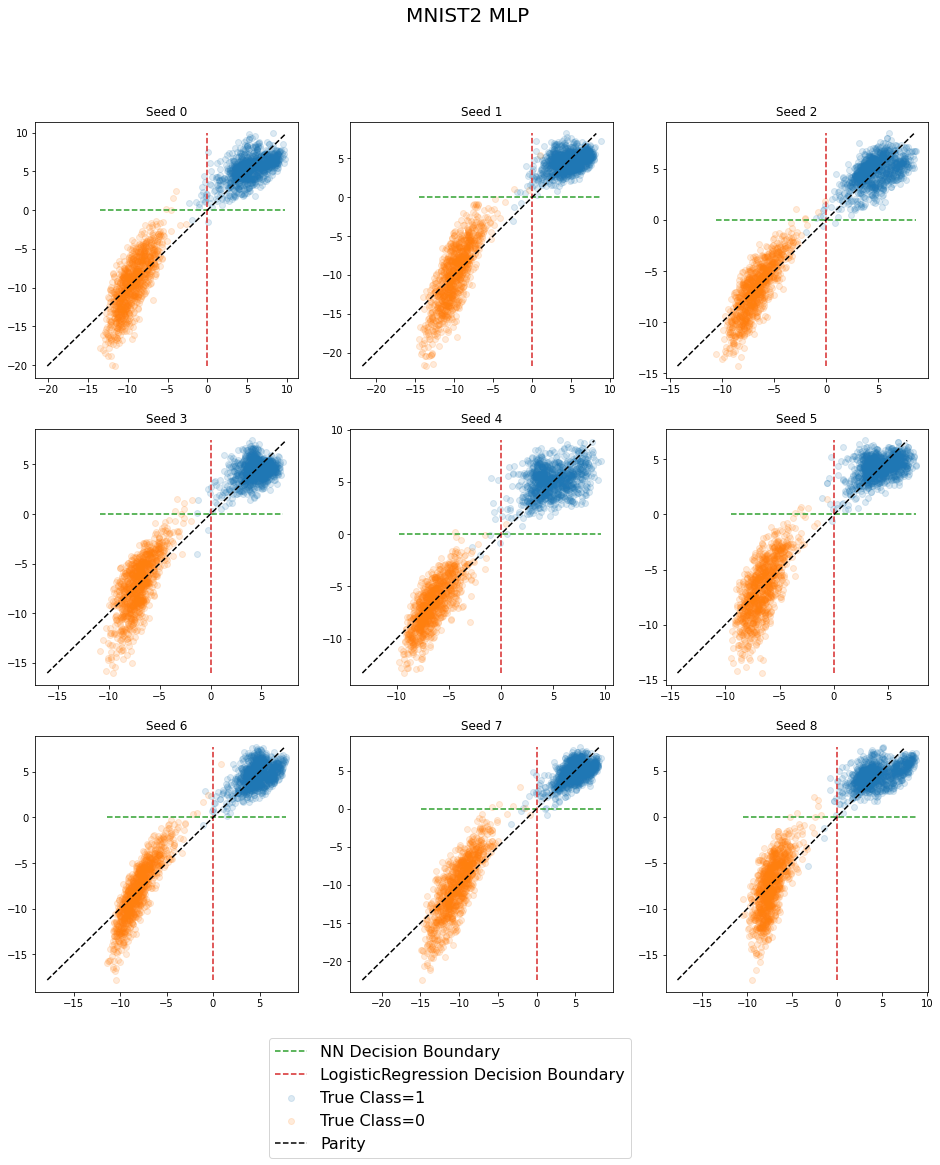

fit R^2 0.8904 +/- 0.0305
tau 0.7077 +/- 0.0034
 
MNIST CNN
train_acc_NN 98.12 +/- 0.10 %
test_acc_NN 98.38 +/- 0.12 %
test_acc_kSVM 99.67 +/- 0.01 %
test_acc_LKR 98.15 +/- 0.20 %


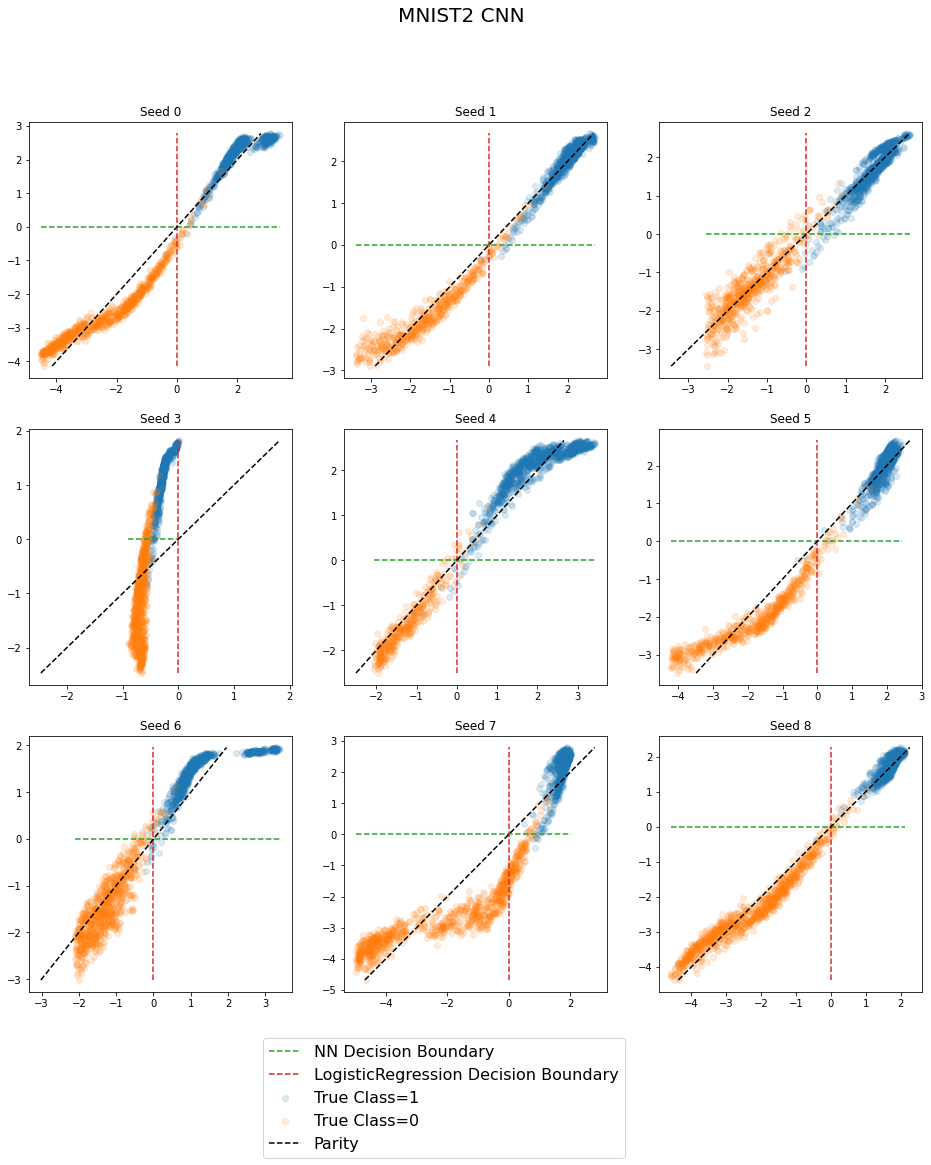

/tmp/ipykernel_65391/3201405575.py:52: RuntimeWarning: overflow encountered in exp
  return np.exp(x) / np.sum(np.exp(x))
/tmp/ipykernel_65391/3201405575.py:52: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(x) / np.sum(np.exp(x))


fit R^2 0.5573 +/- 0.2980
tau 0.8566 +/- 0.0069
 
CIFAR CNN
train_acc_NN 100.00 +/- 0.00 %
test_acc_NN 94.94 +/- 0.05 %
test_acc_kSVM 94.91 +/- 0.04 %
test_acc_LKR 92.84 +/- 0.17 %


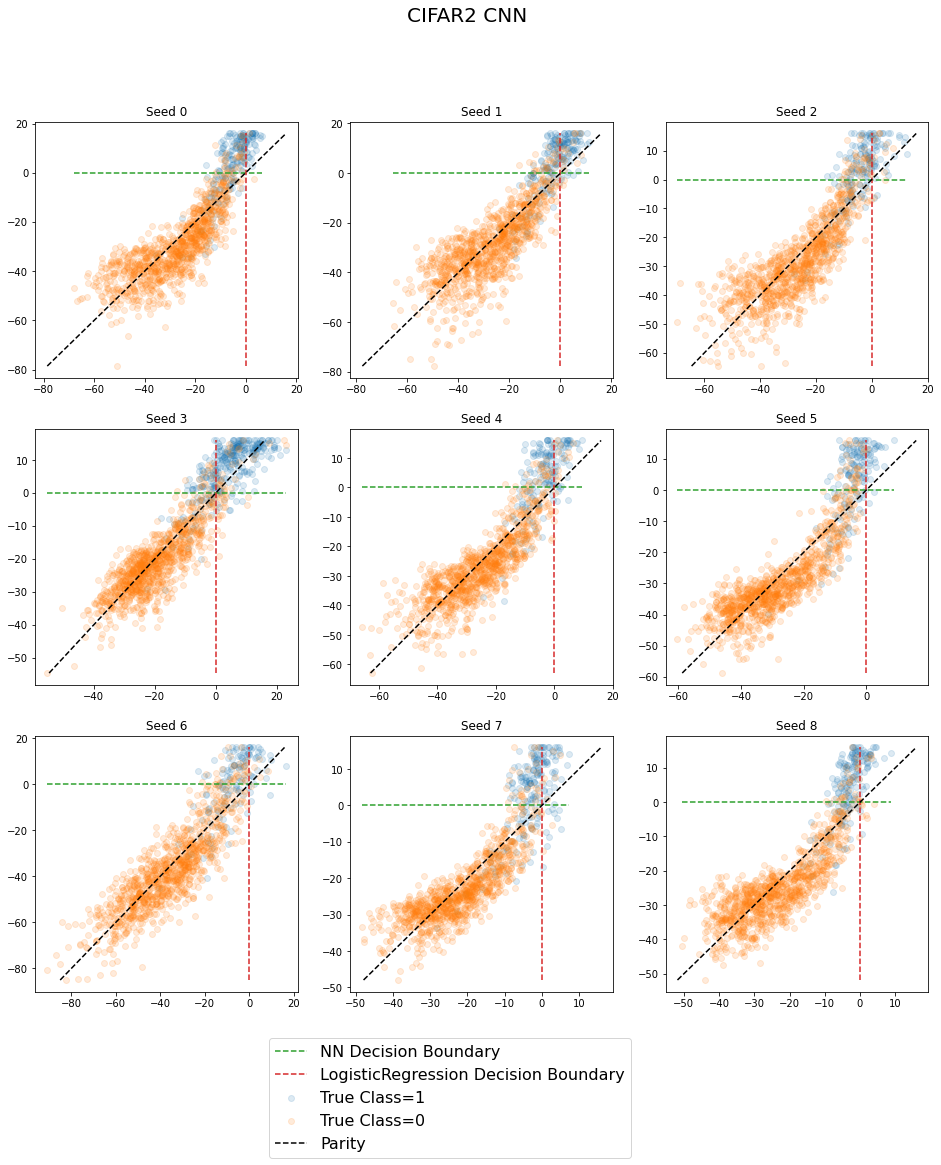

fit R^2 0.6913 +/- 0.0071
tau 0.7113 +/- 0.0034
 
FMNIST CNN
train_acc_NN 98.31 +/- 0.03 %
test_acc_NN 97.95 +/- 0.04 %
test_acc_kSVM 97.85 +/- 0.04 %
test_acc_LKR 95.67 +/- 0.17 %


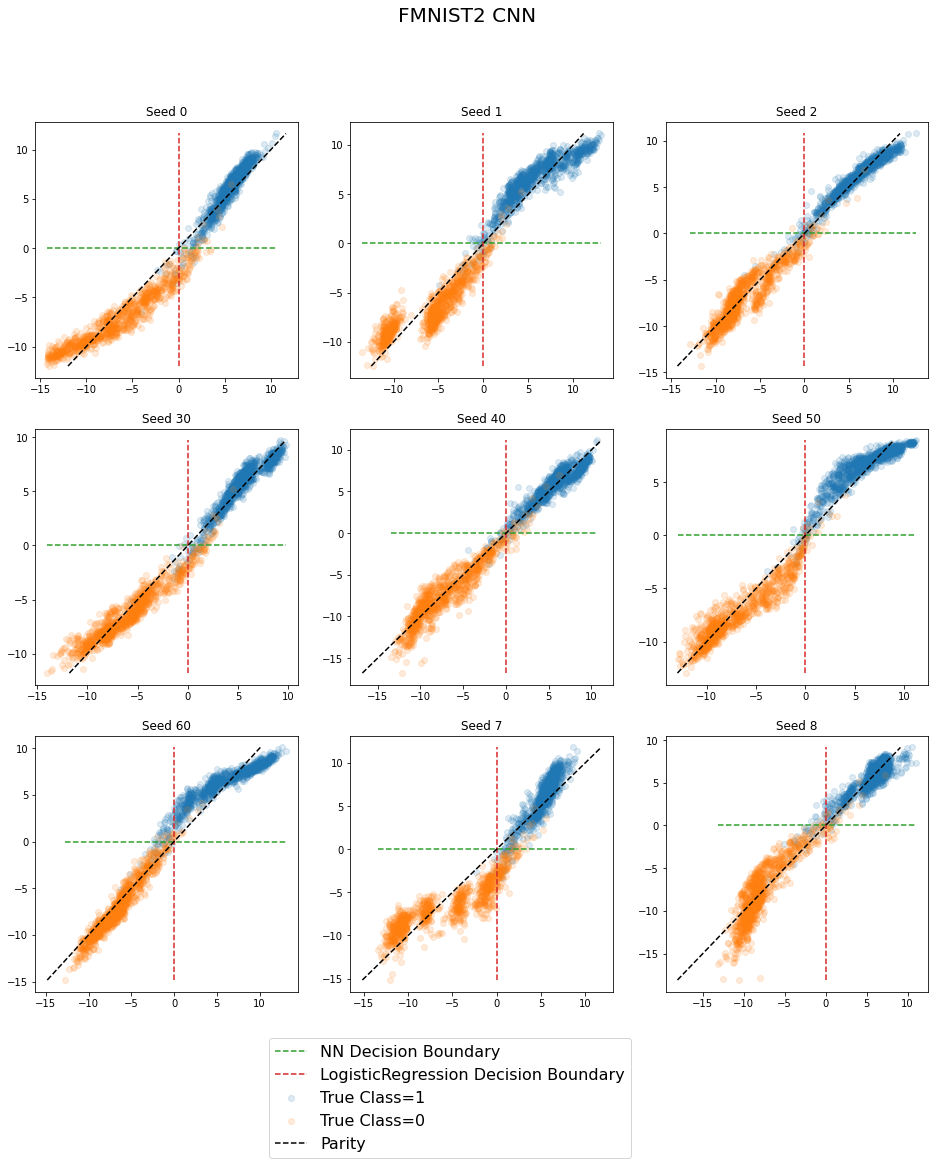

/tmp/ipykernel_65391/3201405575.py:52: RuntimeWarning: overflow encountered in exp
  return np.exp(x) / np.sum(np.exp(x))
/tmp/ipykernel_65391/3201405575.py:52: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(x) / np.sum(np.exp(x))
/tmp/ipykernel_65391/3201405575.py:52: RuntimeWarning: overflow encountered in exp
  return np.exp(x) / np.sum(np.exp(x))
/tmp/ipykernel_65391/3201405575.py:52: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(x) / np.sum(np.exp(x))
/tmp/ipykernel_65391/3201405575.py:52: RuntimeWarning: overflow encountered in exp
  return np.exp(x) / np.sum(np.exp(x))
/tmp/ipykernel_65391/3201405575.py:52: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(x) / np.sum(np.exp(x))
/tmp/ipykernel_65391/3201405575.py:52: RuntimeWarning: overflow encountered in exp
  return np.exp(x) / np.sum(np.exp(x))
/tmp/ipykernel_65391/3201405575.py:52: RuntimeWarning: invalid value encountered in true_divide
  return np

fit R^2 0.9164 +/- 0.0104
tau 0.8821 +/- 0.0026
 


In [17]:
np.random.seed(111221)
print('MNIST MLP')
read_results(results_MNIST_MLP,'LinearizationMNISTMLP.pdf','MNIST2 MLP')
print(' ')

print('MNIST CNN')
read_results(results_MNIST_CNN,'LinearizationMNISTCNN.pdf','MNIST2 CNN')
print(' ')

print('CIFAR CNN')
read_results(results_CIFAR_CNN,'LinearizationCIFARCNN.pdf','CIFAR2 CNN')
print(' ')

print('FMNIST CNN')
read_results(results_FMNIST_CNN,'LinearizationFMNISTCNN.pdf','FMNIST2 CNN')
print(' ')

# Generate Tau and Test Accuracy Differential for SVMs

MNIST MLP
train_acc_NN 99.51 +/- 0.01 %
test_acc_NN 99.64 +/- 0.01 %
test_acc_kSVM 99.92 +/- 0.01 %
test_acc_LKR 99.67 +/- 0.05 %


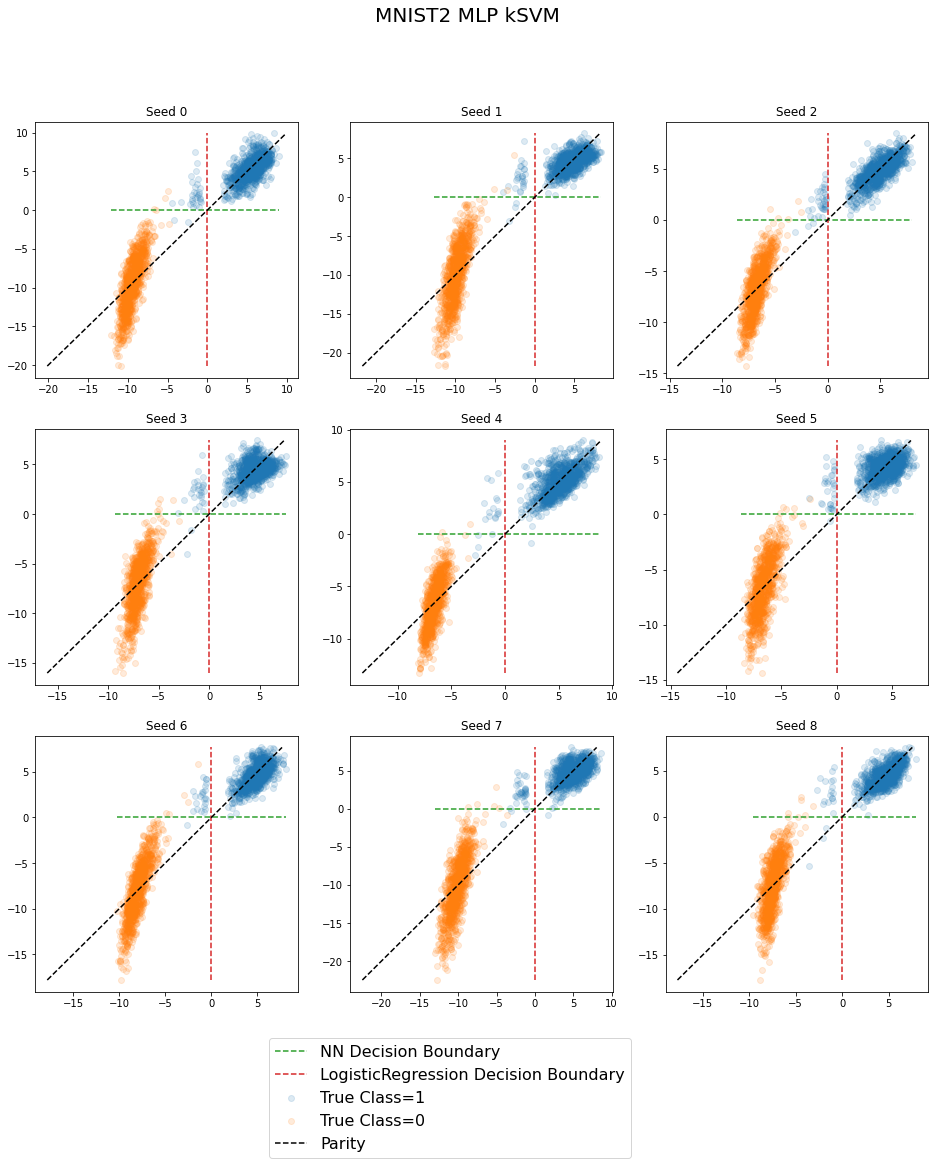

kSVM fit R^2 0.9114 +/- 0.0015
kSVM tau 0.7320 +/- 0.0023
 
MNIST CNN
train_acc_NN 98.12 +/- 0.10 %
test_acc_NN 98.38 +/- 0.12 %
test_acc_kSVM 99.67 +/- 0.01 %
test_acc_LKR 98.15 +/- 0.20 %


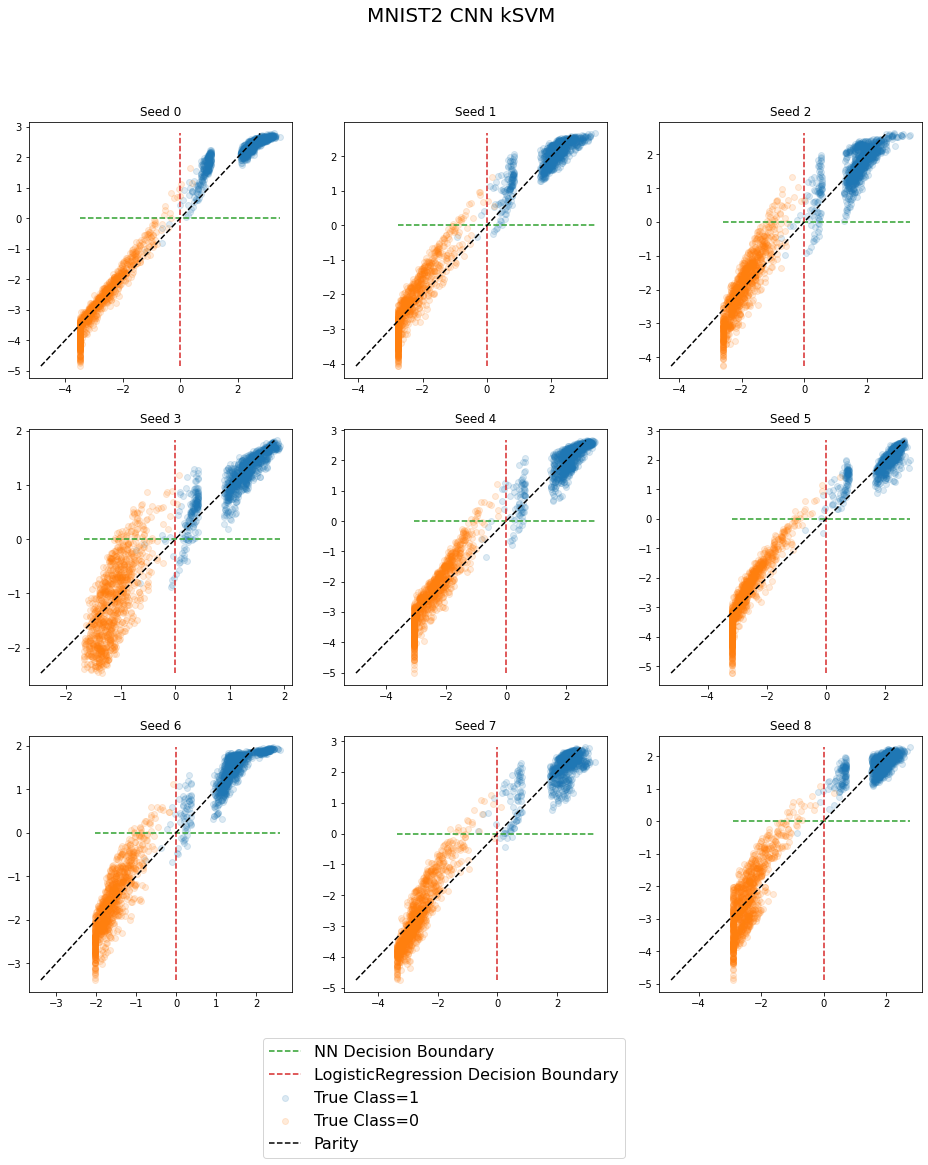

kSVM fit R^2 0.9425 +/- 0.0023
kSVM tau 0.8161 +/- 0.0050
 
CIFAR CNN
train_acc_NN 100.00 +/- 0.00 %
test_acc_NN 94.94 +/- 0.05 %
test_acc_kSVM 94.91 +/- 0.04 %
test_acc_LKR 92.84 +/- 0.17 %


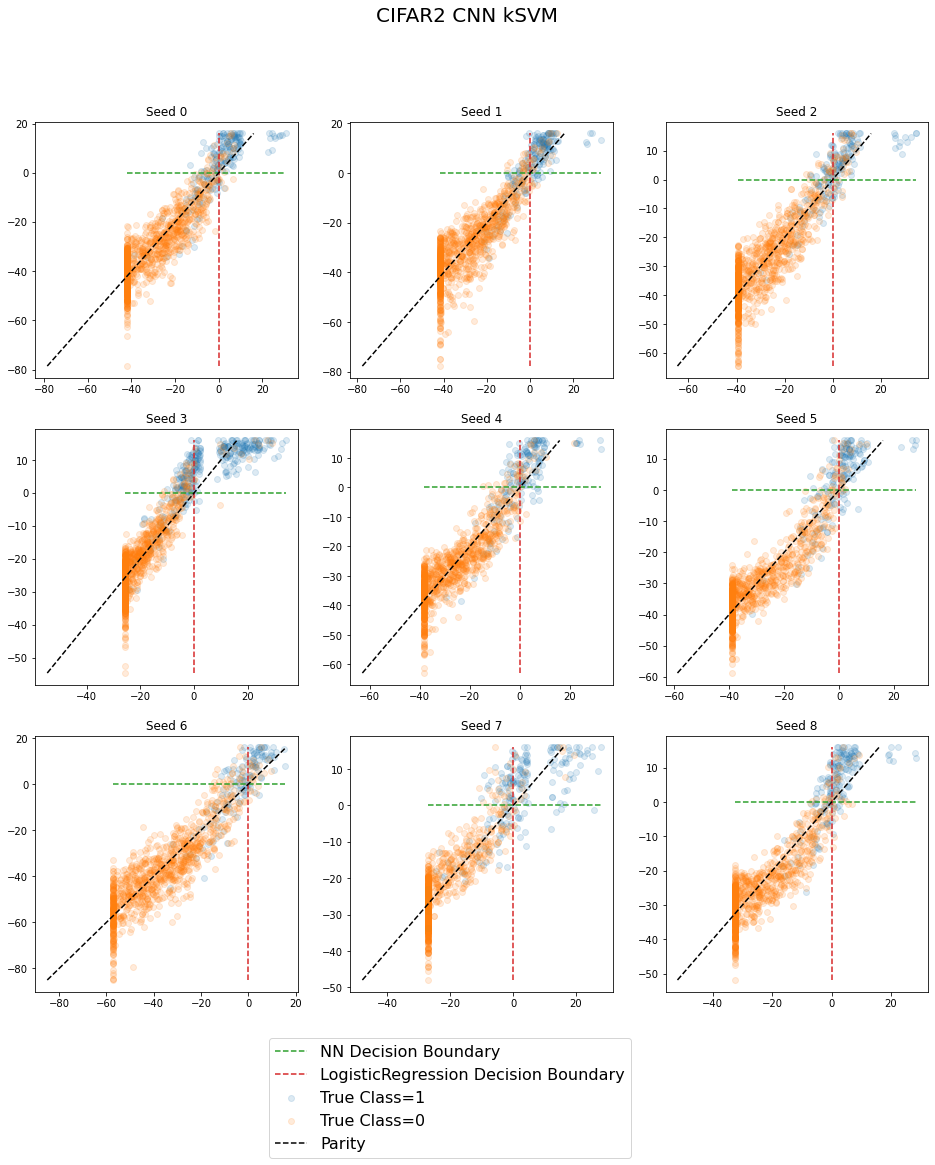

kSVM fit R^2 0.8119 +/- 0.0041
kSVM tau 0.7524 +/- 0.0028
 
FMNIST CNN
train_acc_NN 98.31 +/- 0.03 %
test_acc_NN 97.95 +/- 0.04 %
test_acc_kSVM 97.85 +/- 0.04 %
test_acc_LKR 95.67 +/- 0.17 %


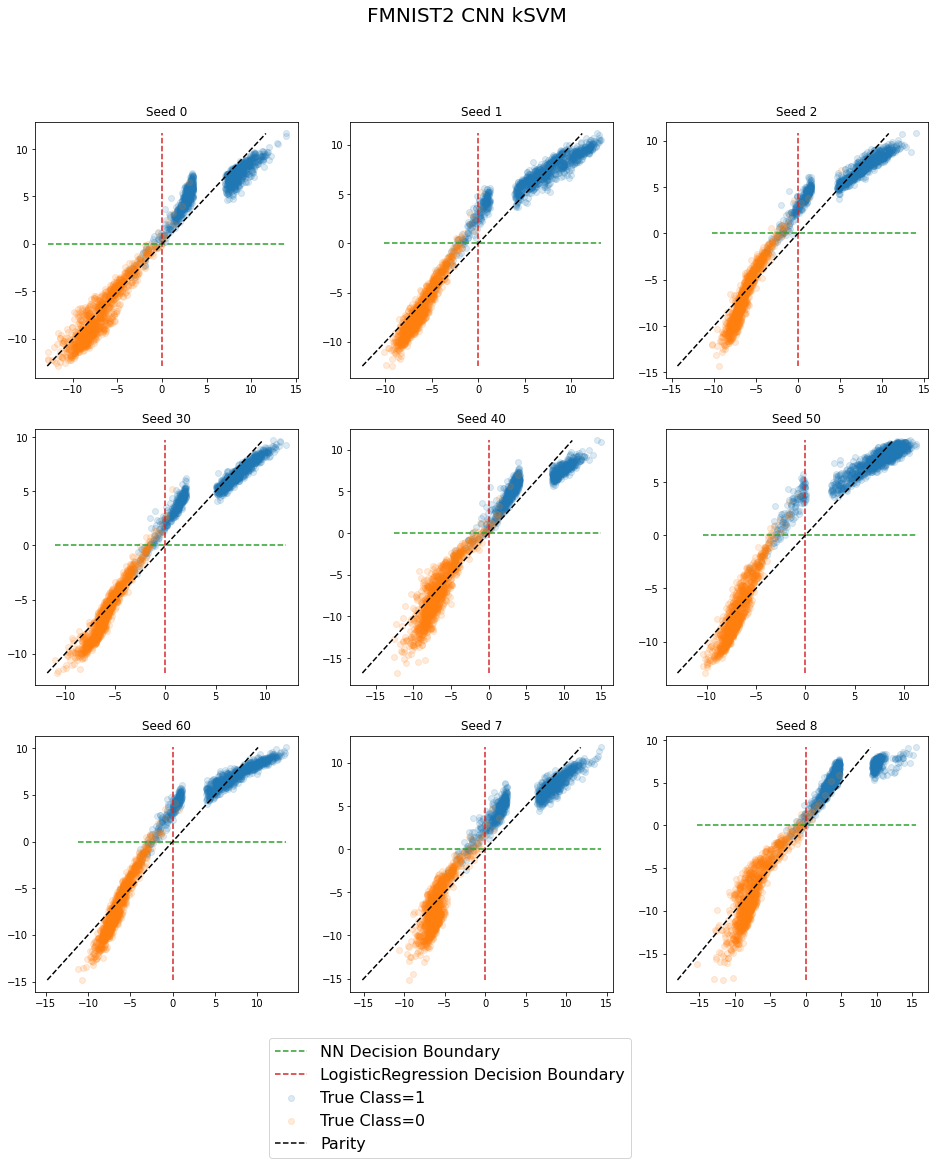

kSVM fit R^2 0.9257 +/- 0.0026
kSVM tau 0.8835 +/- 0.0024
 


In [18]:
np.random.seed(111223)
print('MNIST MLP')
read_resultsSVM(results_MNIST_MLP,'CKLinearizationMNISTMLP.pdf','MNIST2 MLP kSVM')
print(' ')

print('MNIST CNN')
read_resultsSVM(results_MNIST_CNN,'CKLinearizationMNISTCNN.pdf','MNIST2 CNN kSVM')
print(' ')


print('CIFAR CNN')
read_resultsSVM(results_CIFAR_CNN,'CKLinearizationCIFARCNN.pdf','CIFAR2 CNN kSVM')
print(' ')

print('FMNIST CNN')
read_resultsSVM(results_FMNIST_CNN,'CKLinearizationFMNISTCNN.pdf','FMNIST2 CNN kSVM')
print(' ')